In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import data
import shutil
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


## Steps to use the TF Estimator APIs
1. Define dataset **metadata**
2. Define **data input function** to read the data from the source (csv) + **apply pre-processing**
3. Instantiate an **estimator** (KMeans) with **parameters**
4. **Fit** the estimator
5. **Predict** cluster index of each instance
6. **Save** the model and serve it

In [2]:
train_data_files = ['data/train-data.csv']
test_data_files = ['data/test-data.csv']

model_name = 'clust-model-01'

resume = False
train = True
preprocess_features = False
extend_feature_colums = False

## 1. Define Dataset Metadata

In [3]:
HEADER = ['key', 'x1', 'x2', 'x3', 'cluster']  
HEADER_DEFAULTS = [[0], [0.0], [0.0], [0.0], ['NA']]

FEATURE_NAMES = ['x1', 'x2', 'x3']  

UNUSED_FEATURE_NAMES = list(set(HEADER) - set(FEATURE_NAMES))

print("Header: {}".format(HEADER))
print("Input Features: {}".format(FEATURE_NAMES))
print("Unused Features: {}".format(UNUSED_FEATURE_NAMES))

Header: ['key', 'x1', 'x2', 'x3', 'cluster']
Input Features: ['x1', 'x2', 'x3']
Unused Features: ['cluster', 'key']


## 2. Define Data Input Function

### a. parsing and preprocessing logic

In [4]:
def parse_csv_row(csv_row):
    
    columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
    columns = [tf.expand_dims(tensor, -1) for tensor in columns]
    features = dict(zip(HEADER, columns))
    
    for column in UNUSED_FEATURE_NAMES:
        features.pop(column)
    
    return features

def process_features(features):
    
    if preprocess_features:
        features = features
    
    return features

### b. data pipeline input function

In [5]:
def csv_input_fn(file_names, mode=tf.estimator.ModeKeys.TRAIN, 
                 skip_header_lines=0, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = False
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(file_names))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row))
    dataset = dataset.map(lambda features: process_features(features))
    
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator() 
    
    features = iterator.get_next()
    return features, None

In [6]:
features, _ = csv_input_fn(file_names=train_data_files)
print("Feature read from CSV: {}".format(list(features.keys())))


* data input_fn:
Input file(s): ['data/train-data.csv']
Batch size: 200
Epoch Count: None
Mode: train
Shuffle: False

Feature read from CSV: ['x1', 'x2', 'x3']


## 3. Build an Estimator

### a. Define Estimator Creation Function

In [7]:
def create_estimator(run_config, hparams):
    
    estimator = tf.contrib.learn.KMeansClustering(
        num_clusters = hparams.num_clusters,
        initial_clusters= tf.contrib.factorization.RANDOM_INIT,
        distance_metric= tf.contrib.factorization.SQUARED_EUCLIDEAN_DISTANCE,
        use_mini_batch=True,
        mini_batch_steps_per_iteration=1,
        kmeans_plus_plus_num_retries=10,
        relative_tolerance=None,
        config= run_config
    )

    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")
    
    return estimator

### b. Set HParam and RunConfig

In [8]:
hparams  = tf.contrib.training.HParams(
    num_epochs = 1000,
    batch_size = 500,
    num_clusters=3
)

model_dir = 'trained_models/{}'.format(model_name)

run_config = tf.contrib.learn.RunConfig(
    save_checkpoints_steps=100,
    tf_random_seed=19850610,
    model_dir=model_dir
)

print(run_config.model_dir)

trained_models/clust-model-01


## 4. Create Estimator

In [9]:
train_input_fn = lambda: csv_input_fn(
            train_data_files,
            mode = tf.contrib.learn.ModeKeys.TRAIN,
            num_epochs=hparams.num_epochs,
            batch_size=hparams.batch_size
        )

In [10]:
if not resume:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

if train:
    tf.logging.set_verbosity(tf.logging.INFO)
    
    time_start = datetime.utcnow() 
    print("Training started at {}".format(time_start.strftime("%H:%M:%S")))
    print(".......................................") 
    
    estimator = create_estimator(hparams=hparams, run_config=run_config)
    estimator.fit(input_fn=train_input_fn,
                  max_steps=None)

    time_end = datetime.utcnow() 
    print(".......................................")
    print("Training finished at {}".format(time_end.strftime("%H:%M:%S")))
    print("")
    time_elapsed = time_end - time_start
    print("Training elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Training started at 20:36:13
.......................................
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x124bd7358>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19850610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 100, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/clust-model-01'}

Estimator Type: <class 'tensorflow.contrib.learn.python.learn.estimators.kmeans.KMeansClustering'>


* data input_fn:
Input file(s): ['data/train-data.csv']
Batch size: 500
Epoch Count: 1000
Mode: train
Shuffle: False

Instructions for updating:


## 5. Perform Predictions (Assign Instance to Clusters)

In [11]:
train_input_fn = lambda: csv_input_fn(
            train_data_files,
            num_epochs=1,
            batch_size=1500
        )

test_input_fn = lambda: csv_input_fn(
            test_data_files,
            num_epochs=1,
            batch_size=500
        )

train_assignments = list(estimator.predict_cluster_idx(input_fn=train_input_fn))
test_assignments = list(estimator.predict_cluster_idx(input_fn=test_input_fn))


* data input_fn:
Input file(s): ['data/train-data.csv']
Batch size: 1500
Epoch Count: 1
Mode: train
Shuffle: False

INFO:tensorflow:Restoring parameters from trained_models/clust-model-01/model.ckpt-3000

* data input_fn:
Input file(s): ['data/test-data.csv']
Batch size: 500
Epoch Count: 1
Mode: train
Shuffle: False

INFO:tensorflow:Restoring parameters from trained_models/clust-model-01/model.ckpt-3000


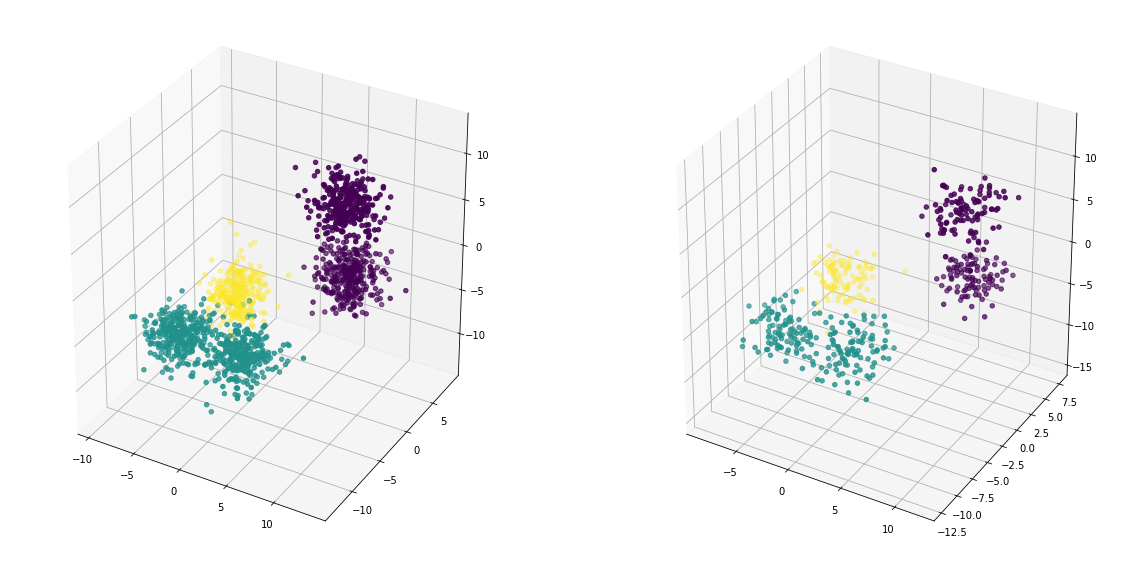

In [12]:
import pandas as pd
import numpy as np

train_df = pd.read_csv(train_data_files[0], header=None, index_col=0)
test_df = pd.read_csv(test_data_files[0], header=None, index_col=0)


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(train_df.iloc[:,0], train_df.iloc[:,1], train_df.iloc[:,2], c=train_assignments, marker='o')

ax = fig.add_subplot(122, projection='3d')

ax.scatter(test_df.iloc[:,0], test_df.iloc[:,1], test_df.iloc[:,2], c=test_assignments, marker='o')
plt.show()

In [13]:
clusters = estimator.clusters()
print("Cluster Centriods:")
print("==================")
print(clusters)

Cluster Centriods:
[[ 8.26997852  0.80968368  3.60038066]
 [-0.66113287 -8.35648823 -5.18023205]
 [-5.76904392  4.08977938 -8.63212681]]
